In [ ]:
import kagglehub
jangedoo_utkface_new_path = kagglehub.dataset_download('jangedoo/utkface-new')

print('Data source import complete.')


Data source import complete.


In [ ]:
import os, logging
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
logging.getLogger('absl').setLevel(logging.ERROR)

import pandas as pd
import numpy as np
import os
import cv2 as cv
from PIL import Image
from keras.preprocessing.image import load_img

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Dense,Conv2D,Dropout,Flatten,MaxPooling2D,Input

from tensorflow.keras.utils import plot_model
from pathlib import Path
from sklearn.model_selection import train_test_split
from tensorflow.keras.initializers import random_uniform,glorot_uniform,constant,identity
from tensorflow.keras.layers import Add,BatchNormalization,GlobalMaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras import datasets,layers,models

In [ ]:
BASE_DIRS = [r'/kaggle/input/utkface-new/UTKFace']

In [ ]:
image_paths = []
age_labels = []
gender_labels = []

In [ ]:
!pip install -q tqdm
from tqdm import tqdm

In [ ]:
for BASE_DIR in BASE_DIRS:
    for filename in tqdm(os.listdir(BASE_DIR)):
        temp = filename.split('_')
        if temp[0].isdigit():
            age = int(temp[0])
            gender = int(temp[1])
            image_path = os.path.join(BASE_DIR,filename)
            image_paths.append(image_path)
            age_labels.append(age)
            gender_labels.append(gender)

100%|██████████| 23708/23708 [00:00<00:00, 579722.02it/s]


In [ ]:
print(len(image_paths), len(age_labels), len(gender_labels))


23708 23708 23708


In [ ]:
df = pd.DataFrame()
df['image'], df['age'], df['gender'] = image_paths, age_labels, gender_labels
df.head()

,image,age,gender
0,/kaggle/input/utkface-new/UTKFace/26_0_2_20170...,26,0
1,/kaggle/input/utkface-new/UTKFace/22_1_1_20170...,22,1
2,/kaggle/input/utkface-new/UTKFace/21_1_3_20170...,21,1
3,/kaggle/input/utkface-new/UTKFace/28_0_0_20170...,28,0
4,/kaggle/input/utkface-new/UTKFace/17_1_4_20170...,17,1


In [ ]:
print(f"DataFrame:{df}")
print(f"DataFrame shape:{df.shape}")
print(f"first few rows of the dataframe:{df.head()}")

DataFrame:                                                   image  age  gender
0      /kaggle/input/utkface-new/UTKFace/26_0_2_20170...   26       0
1      /kaggle/input/utkface-new/UTKFace/22_1_1_20170...   22       1
2      /kaggle/input/utkface-new/UTKFace/21_1_3_20170...   21       1
3      /kaggle/input/utkface-new/UTKFace/28_0_0_20170...   28       0
4      /kaggle/input/utkface-new/UTKFace/17_1_4_20170...   17       1
...                                                  ...  ...     ...
23703  /kaggle/input/utkface-new/UTKFace/41_0_0_20170...   41       0
23704  /kaggle/input/utkface-new/UTKFace/42_0_0_20170...   42       0
23705  /kaggle/input/utkface-new/UTKFace/2_0_2_201612...    2       0
23706  /kaggle/input/utkface-new/UTKFace/65_1_0_20170...   65       1
23707  /kaggle/input/utkface-new/UTKFace/66_0_1_20170...   66       0

[23708 rows x 3 columns]
DataFrame shape:(23708, 3)
first few rows of the dataframe:                                               image  age  gender

In [ ]:
gender_dict = {0:'Male', 1:'Female'}

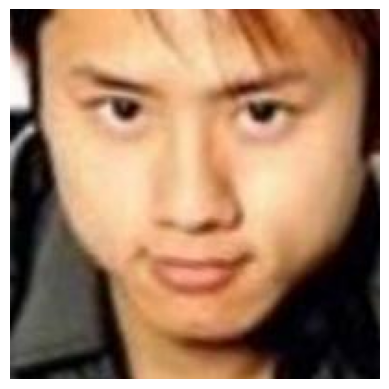

In [ ]:
if not df.empty:
    try:
        img = Image.open(df['image'][0])
        plt.axis('off')
        plt.imshow(img)
        plt.show()
    except Exception as e:
        print(f"Error opening image:{e}")
else:
    print(f"Dataframe is empty, no images found.")

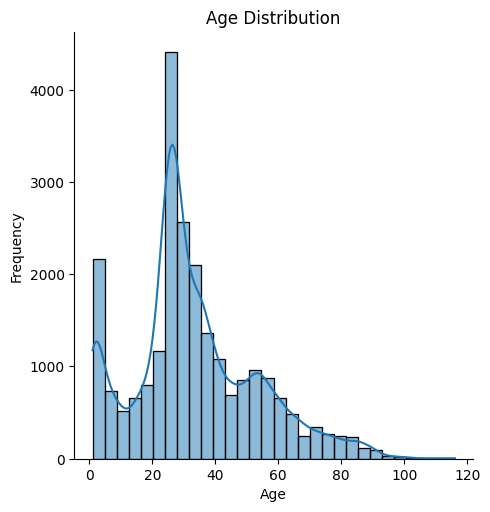

In [ ]:
sns.displot(df['age'],kde=True,bins=30)
plt.title("Age Distribution")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()

In [ ]:
from PIL import Image

In [ ]:
plt.figure(figsize=(25,25))
files = df.iloc[0:25]

<Figure size 2500x2500 with 0 Axes>

In [ ]:
def extract_feature(images):
    features = []
    for image in tqdm(images):
        img = Image.open(image).convert('L')
        img = img.resize((128, 128), Image.BILINEAR)

        img = np.array(img)
        features.append(img)

    features = np.array(features)

    features = features.reshape(len(features),128,128,1)
    return features

In [ ]:
X = extract_feature(df['image'])
print(f"X_shape: \t{X.shape}")

100%|██████████| 23708/23708 [01:08<00:00, 344.39it/s]


X_shape: 	(23708, 128, 128, 1)


In [ ]:
X = X/255.0
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])

print("shape of y_gender:", y_gender.shape)
print("shape of y_age:", y_age.shape)

shape of y_gender: (23708,)
shape of y_age: (23708,)


In [ ]:
input_shape = (128,128,1)
inputs = Input(input_shape)

conv1 = Conv2D(32,kernel_size=(3,3),activation='relu')(inputs)
maxp1 = MaxPooling2D(pool_size=(2,2))(conv1)

conv2 = Conv2D(64,kernel_size=(3,3),activation='relu')(maxp1)
maxp2 = MaxPooling2D(pool_size=(2,2))(conv2)

conv3 = Conv2D(128,kernel_size=(3,3),activation='relu')(maxp2)
maxp3 = MaxPooling2D(pool_size=(2,2))(conv3)

conv4 = Conv2D(256,kernel_size=(3,3),activation='relu')(maxp3)
maxp4 = MaxPooling2D(pool_size=(2,2))(conv4)

flatten = Flatten()(maxp4)

dense1 = Dense(256,activation='relu')(flatten)
dense2 = Dense(256,activation='relu')(flatten)

dropout1 = Dropout(0.3)(dense1)
dropout2 = Dropout(0.3)(dense2)

output1 = Dense(1,activation='sigmoid', name='gender_out')(dropout1)
output2 = Dense(1,activation='relu', name='age_out')(dropout2)

model = Model(inputs=inputs, outputs=[output1,output2])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 126, 126,  │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 63, 63,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 61, 61,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 30, 30,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 28, 28,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 14, 14,    │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 12, 12,    │    295,168 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 6, 6, 256) │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 9216)      │          0 │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │  2,359,552 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │  2,359,552 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gender_out (Dense)  │ (None, 1)         │        257 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ age_out (Dense)     │ (None, 1)         │        257 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,107,458 (19.48 MB)

 Trainable params: 5,107,458 (19.48 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
y_combined = np.column_stack((y_gender,y_age))
X_train,X_temp,y_combined_train,y_combined_temp = train_test_split(
    X,y_combined,test_size=0.2,random_state=42
)

X_test,X_val,y_combined_test,y_combined_val = train_test_split(
    X_temp,y_combined_temp,test_size=0.5,random_state=42
)

In [ ]:
y_train_gender, y_train_age = y_combined_train[:,0],y_combined_train[:,1]
y_test_gender,y_test_age = y_combined_test[:,0],y_combined_test[:,1]
y_val_gender,y_val_age = y_combined_val[:,0],y_combined_val[:,1]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

model_path = '/content/drive/MyDrive/best_model.keras'

checkpointer = ModelCheckpoint(
    filepath=model_path,
    monitor='val_gender_out_accuracy',
    verbose=1,
    mode='max',
    save_best_only=True
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1,
    mode='min',
    min_lr=1e-6
)

callbacks = [checkpointer, lr_scheduler]

In [ ]:
model.compile(
    optimizer='adam',
    loss={
        'gender_out': 'binary_crossentropy',
        'age_out': 'mse'
    },
    metrics={
        'gender_out': 'accuracy',
        'age_out': 'mae'
    }
)

In [ ]:
total_images = len(image_paths)
print(f"Total number of images:{total_images}")

Total number of images:23708


In [ ]:
train_images = len(X_train)
validation_images = len(X_val)
test_images = len(X_test)

print(f"Number of the training images:{train_images}")
print(f"Number of the validation images:{validation_images}")
print(f"Number of the test images:{test_images}")

Number of the training images:18966
Number of the validation images:2371
Number of the test images:2371


In [ ]:
print(X_train.shape)
print(X_val.shape)

(18966, 128, 128, 1)
(2371, 128, 128, 1)


In [ ]:
import tensorflow as tf
tf.config.run_functions_eagerly(True)

In [ ]:
history = model.fit(
    x=X_train,
    y=[y_train_gender, y_train_age],
    batch_size=128,
    epochs=100,
    validation_data=(X_val, [y_val_gender, y_val_age]),
    callbacks=[checkpointer, lr_scheduler]
)

Epoch 1/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - age_out_loss: 560.4072 - age_out_mae: 18.1843 - gender_out_accuracy: 0.5231 - gender_out_loss: 0.7304 - loss: 561.1375
Epoch 1: val_gender_out_accuracy improved from -inf to 0.64530, saving model to /content/drive/MyDrive/second_model.keras
149/149 ━━━━━━━━━━━━━━━━━━━━ 38s 212ms/step - age_out_loss: 559.6315 - age_out_mae: 18.1711 - gender_out_accuracy: 0.5231 - gender_out_loss: 0.7302 - loss: 560.3617 - val_age_out_loss: 374.4235 - val_age_out_mae: 14.3685 - val_gender_out_accuracy: 0.6453 - val_gender_out_loss: 0.6866 - val_loss: 375.1101 - learning_rate: 0.0010
Epoch 2/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - age_out_loss: 381.2351 - age_out_mae: 15.0200 - gender_out_accuracy: 0.5860 - gender_out_loss: 0.6712 - loss: 381.9064
Epoch 2: val_gender_out_accuracy improved from 0.64530 to 0.71615, saving model to /content/drive/MyDrive/second_model.keras
149/149 ━━━━━━━━━━━━━━━━━━━━ 31s 184ms/step - age_out_loss: 381.0299 - 

In [ ]:
model.save('age_gender_model_v.keras')

In [ ]:
from google.colab import files
files.download('age_gender_model_v.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>